# Resume Transformer Workflow Agent using LangGraph

This notebook implements a complete resume processing workflow using LangGraph and OpenAI's GPT-4o-mini model.

## Workflow Steps:
1. **Parse**: Extract raw text from resume files (PDF, DOCX, TXT)
2. **Extract**: Use LLM to extract structured data into JSON
3. **Validate & Enrich**: Clean data, calculate experience, standardize skills
4. **Store**: Insert structured data into database

## Installation
First, install the required dependencies:

In [2]:
!pip install langgraph openai pypdf2 python-docx pytesseract pillow pdf2image

  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached pytesseract-0.3.13-py3-none-any.whl.metadata (11 kB)
  Using cached pillow-12.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pdf2image-1.17.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached xxhash-3.6.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached anyio-4.12.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.

In [4]:
pip install python-dotenv

  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

Installing required libraries.

In [5]:
import os
import json
import re
import sqlite3
from datetime import datetime
from typing import TypedDict, Optional, List, Dict, Any
from pathlib import Path

# Document parsing
import PyPDF2
import docx

# LangGraph
from langgraph.graph import StateGraph, END

# OpenAI
from openai import OpenAI

from dotenv import load_dotenv
load_dotenv()
# Access the variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Set up OpenAI client
# Make sure to set your OPENAI_API_KEY environment variable

client = OpenAI(api_key=OPENAI_API_KEY)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Define State Schema

The state will be passed between all agents in the workflow.

In [6]:
class ResumeState(TypedDict):
    """State schema for the resume transformation workflow"""
    # Input
    file_path: str
    file_type: str
    
    # Step 1: Parse
    raw_text: Optional[str]
    parse_error: Optional[str]
    
    # Step 2: Extract
    structured_data: Optional[Dict[str, Any]]
    extract_error: Optional[str]
    
    # Step 3: Validate & Enrich
    validated_data: Optional[Dict[str, Any]]
    validation_error: Optional[str]
    
    # Step 4: Store
    database_id: Optional[int]
    store_error: Optional[str]
    
    # Metadata
    status: str
    messages: List[str]

print("✓ State schema defined!")

✓ State schema defined!


## Step 1: Parse Agent

Extracts raw text from PDF, DOCX, or TXT files.

In [29]:
def parse_pdf(file_path: str) -> str:
    """Extract text from PDF file, with OCR fallback for image-based PDFs"""
    text = ""
    try:
        # First, try regular text extraction
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        
        # If no text was extracted, the PDF is likely image-based, try OCR
        if not text.strip():
            print("   ⚠️ No text found in PDF - attempting OCR extraction...")
            try:
                from pdf2image import convert_from_path
                import pytesseract
                
                # Convert PDF pages to images
                images = convert_from_path(file_path)
                
                # Perform OCR on each page
                for i, image in enumerate(images):
                    page_text = pytesseract.image_to_string(image)
                    text += page_text + "\n"
                    print(f"   ✓ OCR extracted {len(page_text)} characters from page {i+1}")
                
            except ImportError:
                raise Exception(
                    "PDF appears to be image-based but OCR libraries not available. "
                    "Install with: pip install pytesseract pdf2image pillow"
                )
            except Exception as e:
                raise Exception(f"OCR extraction failed: {str(e)}")
                
    except Exception as e:
        raise Exception(f"Error parsing PDF: {str(e)}")
    
    return text.strip()

def parse_docx(file_path: str) -> str:
    """Extract text from DOCX file"""
    try:
        doc = docx.Document(file_path)
        text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
    except Exception as e:
        raise Exception(f"Error parsing DOCX: {str(e)}")
    return text.strip()

def parse_txt(file_path: str) -> str:
    """Extract text from TXT file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
    except Exception as e:
        raise Exception(f"Error parsing TXT: {str(e)}")
    return text.strip()

def parse_agent(state: ResumeState) -> ResumeState:
    """
    Agent 1: Parse - Extract raw text from resume file
    """
    print(f"🔍 PARSE AGENT: Processing {state['file_path']}")
    
    try:
        file_type = state['file_type'].lower()
        
        if file_type == 'pdf':
            raw_text = parse_pdf(state['file_path'])
        elif file_type == 'docx':
            raw_text = parse_docx(state['file_path'])
        elif file_type == 'txt':
            raw_text = parse_txt(state['file_path'])
        else:
            raise ValueError(f"Unsupported file type: {file_type}")
        
        state['raw_text'] = raw_text
        state['parse_error'] = None
        state['messages'].append(f"✓ Successfully parsed {len(raw_text)} characters from {file_type.upper()}")
        print(f"   ✓ Extracted {len(raw_text)} characters")
        
    except Exception as e:
        state['parse_error'] = str(e)
        state['messages'].append(f"✗ Parse error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Parse agent defined!")

✓ Parse agent defined!


## Step 2: Extract Agent

Uses GPT-4o-mini to extract structured data from the raw text.

In [30]:
def extract_agent(state: ResumeState) -> ResumeState:
    """
    Agent 2: Extract - Use LLM to extract structured data from raw text
    """
    print(f"🤖 EXTRACT AGENT: Analyzing resume with GPT-4o-mini")
    
    if state.get('parse_error'):
        state['extract_error'] = "Cannot extract: parsing failed"
        return state
    
    try:
        # Prepare the prompt for GPT-4o-mini
        system_prompt = """You are an expert resume parsing engine. Your task is to extract structured, normalized data from raw resume text and return it as VALID JSON ONLY.

        Follow these rules strictly:
        - Output MUST be a single JSON object and nothing else (no markdown, no comments).
        - If a field is missing or not found, use null or an empty array (never invent data).
        - Normalize capitalization (Title Case for names, companies, titles).
        - Deduplicate repeated skills, certifications, and languages.
        - Do not infer dates or employers unless explicitly stated.
        - Keep descriptions concise and factual.

        Extract the following schema exactly:

        {
        "contact": {
            "name": string | null,
            "email": string | null,
            "phone": string | null,
            "location": string | null,
            "linkedin": string | null,
            "github": string | null
        },
        "summary": string | null,
        "experience": [
            {
            "company": string | null,
            "title": string | null,
            "start_date": string | null,
            "end_date": string | null,
            "description": string | null,
            "responsibilities": [string]
            }
        ],
        "education": [
            {
            "institution": string | null,
            "degree": string | null,
            "field": string | null,
            "graduation_year": string | null
            }
        ],
        "skills": [string],
        "certifications": [string],
        "languages": [string]
        }

        Date formatting rules:
        - Use "YYYY-MM" when month is available.
        - Use "YYYY" if only the year is available.
        - Use "Present" for ongoing roles.

        Responsibilities should be concise bullet-style statements (max 1 sentence each)."""

        user_prompt = f"Resume text:\n\n{state['raw_text']}"
        
        # Call OpenAI API
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.1,
            response_format={"type": "json_object"}
        )
        
        # Parse the response
        extracted_text = response.choices[0].message.content
        structured_data = json.loads(extracted_text)
        
        state['structured_data'] = structured_data
        state['extract_error'] = None
        state['messages'].append("✓ Successfully extracted structured data using GPT-4o-mini")
        print(f"   ✓ Extracted data for: {structured_data.get('contact', {}).get('name', 'Unknown')}")
        
    except Exception as e:
        state['extract_error'] = str(e)
        state['messages'].append(f"✗ Extract error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Extract agent defined!")

✓ Extract agent defined!


## Step 3: Validate & Enrich Agent

Cleans data, calculates total years of experience, and standardizes skills.

In [10]:
# Standard skills taxonomy for normalization
STANDARD_SKILLS = {
    # Programming Languages
    'python': 'Python', 'java': 'Java', 'javascript': 'JavaScript', 'js': 'JavaScript',
    'typescript': 'TypeScript', 'c++': 'C++', 'c#': 'C#', 'ruby': 'Ruby',
    'go': 'Go', 'rust': 'Rust', 'swift': 'Swift', 'kotlin': 'Kotlin', 'php': 'PHP',
    
    # Frameworks
    'react': 'React', 'reactjs': 'React', 'angular': 'Angular', 'vue': 'Vue.js',
    'django': 'Django', 'flask': 'Flask', 'spring': 'Spring', 'nodejs': 'Node.js',
    'express': 'Express.js', 'fastapi': 'FastAPI',
    
    # Databases
    'sql': 'SQL', 'mysql': 'MySQL', 'postgresql': 'PostgreSQL', 'mongodb': 'MongoDB',
    'redis': 'Redis', 'oracle': 'Oracle', 'dynamodb': 'DynamoDB',
    
    # Cloud & DevOps
    'aws': 'AWS', 'azure': 'Azure', 'gcp': 'Google Cloud', 'docker': 'Docker',
    'kubernetes': 'Kubernetes', 'k8s': 'Kubernetes', 'terraform': 'Terraform',
    'jenkins': 'Jenkins', 'ci/cd': 'CI/CD', 'git': 'Git',
    
    # Data Science & ML
    'machine learning': 'Machine Learning', 'ml': 'Machine Learning',
    'deep learning': 'Deep Learning', 'tensorflow': 'TensorFlow',
    'pytorch': 'PyTorch', 'pandas': 'Pandas', 'numpy': 'NumPy',
    'scikit-learn': 'Scikit-learn', 'nlp': 'NLP',
    
    # Other
    'agile': 'Agile', 'scrum': 'Scrum', 'rest api': 'REST API',
    'graphql': 'GraphQL', 'microservices': 'Microservices'
}

def parse_date(date_str: str) -> Optional[datetime]:
    """Parse various date formats"""
    if not date_str or date_str.lower() in ['present', 'current', 'now']:
        return datetime.now()
    
    # Try different formats
    formats = ['%Y-%m', '%Y', '%m/%Y', '%B %Y', '%b %Y']
    for fmt in formats:
        try:
            return datetime.strptime(str(date_str).strip(), fmt)
        except:
            continue
    return None

def calculate_experience(experience_list: List[Dict]) -> float:
    """Calculate total years of experience"""
    total_months = 0
    
    for job in experience_list:
        start = parse_date(job.get('start_date', ''))
        end = parse_date(job.get('end_date', ''))
        
        if start and end:
            months = (end.year - start.year) * 12 + (end.month - start.month)
            total_months += max(0, months)
    
    return round(total_months / 12, 1)

def standardize_skills(skills: List[str]) -> List[str]:
    """Normalize skills to standard taxonomy"""
    standardized = set()
    
    for skill in skills:
        skill_lower = skill.lower().strip()
        # Check if skill matches standard taxonomy
        if skill_lower in STANDARD_SKILLS:
            standardized.add(STANDARD_SKILLS[skill_lower])
        else:
            # Keep original if not in taxonomy
            standardized.add(skill.strip())
    
    return sorted(list(standardized))

def clean_contact_info(contact: Dict) -> Dict:
    """Clean and validate contact information"""
    cleaned = {}
    
    # Clean email
    if contact.get('email'):
        email = contact['email'].strip().lower()
        if '@' in email:
            cleaned['email'] = email
    
    # Clean phone
    if contact.get('phone'):
        phone = re.sub(r'[^\d+\-() ]', '', contact['phone'])
        cleaned['phone'] = phone
    
    # Copy other fields
    for field in ['name', 'location', 'linkedin', 'github']:
        if contact.get(field):
            cleaned[field] = contact[field].strip()
    
    return cleaned

def validate_and_enrich_agent(state: ResumeState) -> ResumeState:
    """
    Agent 3: Validate & Enrich - Clean data, calculate experience, standardize skills
    """
    print(f"✨ VALIDATE & ENRICH AGENT: Processing data")
    
    if state.get('extract_error'):
        state['validation_error'] = "Cannot validate: extraction failed"
        return state
    
    try:
        data = state['structured_data'].copy()
        
        # Clean contact info
        if data.get('contact'):
            data['contact'] = clean_contact_info(data['contact'])
        
        # Calculate total experience
        if data.get('experience'):
            total_experience = calculate_experience(data['experience'])
            data['total_years_experience'] = total_experience
            print(f"   ✓ Calculated {total_experience} years of experience")
        
        # Standardize skills
        if data.get('skills'):
            original_count = len(data['skills'])
            data['skills'] = standardize_skills(data['skills'])
            print(f"   ✓ Standardized {original_count} skills to {len(data['skills'])} unique skills")
        
        # Add metadata
        data['processed_date'] = datetime.now().isoformat()
        data['data_version'] = '1.0'
        
        state['validated_data'] = data
        state['validation_error'] = None
        state['messages'].append("✓ Successfully validated and enriched data")
        
    except Exception as e:
        state['validation_error'] = str(e)
        state['messages'].append(f"✗ Validation error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Validate & Enrich agent defined!")

✓ Validate & Enrich agent defined!


## Step 4: Store Agent

Formats data into SQL and inserts into the database.

In [11]:
def initialize_database(db_path: str = "resume_ats.db"):
    """Initialize the ATS database with required tables"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Create candidates table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS candidates (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            email TEXT,
            phone TEXT,
            location TEXT,
            linkedin TEXT,
            github TEXT,
            summary TEXT,
            total_years_experience REAL,
            processed_date TEXT,
            data_version TEXT,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    ''')
    
    # Create experience table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS experience (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            company TEXT,
            title TEXT,
            start_date TEXT,
            end_date TEXT,
            description TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    # Create education table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS education (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            institution TEXT,
            degree TEXT,
            field TEXT,
            graduation_year TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    # Create skills table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS skills (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            skill TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    # Create certifications table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS certifications (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            candidate_id INTEGER,
            certification TEXT,
            FOREIGN KEY (candidate_id) REFERENCES candidates (id)
        )
    ''')
    
    conn.commit()
    conn.close()

def store_agent(state: ResumeState, db_path: str = "resume_ats.db") -> ResumeState:
    """
    Agent 4: Store - Insert structured data into database
    """
    print(f"💾 STORE AGENT: Saving to database")
    
    if state.get('validation_error'):
        state['store_error'] = "Cannot store: validation failed"
        return state
    
    try:
        # Initialize database
        initialize_database(db_path)
        
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        data = state['validated_data']
        contact = data.get('contact', {})
        
        # Insert candidate
        cursor.execute('''
            INSERT INTO candidates 
            (name, email, phone, location, linkedin, github, summary, 
             total_years_experience, processed_date, data_version)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            contact.get('name'),
            contact.get('email'),
            contact.get('phone'),
            contact.get('location'),
            contact.get('linkedin'),
            contact.get('github'),
            data.get('summary'),
            data.get('total_years_experience'),
            data.get('processed_date'),
            data.get('data_version')
        ))
        
        candidate_id = cursor.lastrowid
        
        # Insert experience
        for exp in data.get('experience', []):
            cursor.execute('''
                INSERT INTO experience 
                (candidate_id, company, title, start_date, end_date, description)
                VALUES (?, ?, ?, ?, ?, ?)
            ''', (
                candidate_id,
                exp.get('company'),
                exp.get('title'),
                exp.get('start_date'),
                exp.get('end_date'),
                exp.get('description')
            ))
        
        # Insert education
        for edu in data.get('education', []):
            cursor.execute('''
                INSERT INTO education 
                (candidate_id, institution, degree, field, graduation_year)
                VALUES (?, ?, ?, ?, ?)
            ''', (
                candidate_id,
                edu.get('institution'),
                edu.get('degree'),
                edu.get('field'),
                edu.get('graduation_year')
            ))
        
        # Insert skills
        for skill in data.get('skills', []):
            cursor.execute('''
                INSERT INTO skills (candidate_id, skill)
                VALUES (?, ?)
            ''', (candidate_id, skill))
        
        # Insert certifications
        for cert in data.get('certifications', []):
            cursor.execute('''
                INSERT INTO certifications (candidate_id, certification)
                VALUES (?, ?)
            ''', (candidate_id, cert))
        
        conn.commit()
        conn.close()
        
        state['database_id'] = candidate_id
        state['store_error'] = None
        state['status'] = 'completed'
        state['messages'].append(f"✓ Successfully stored candidate with ID {candidate_id}")
        print(f"   ✓ Stored candidate with ID: {candidate_id}")
        
    except Exception as e:
        state['store_error'] = str(e)
        state['status'] = 'failed'
        state['messages'].append(f"✗ Store error: {str(e)}")
        print(f"   ✗ Error: {str(e)}")
    
    return state

print("✓ Store agent defined!")

✓ Store agent defined!


## Build LangGraph Workflow

Now let's create the LangGraph state machine that orchestrates all agents.

✓ LangGraph workflow created successfully!


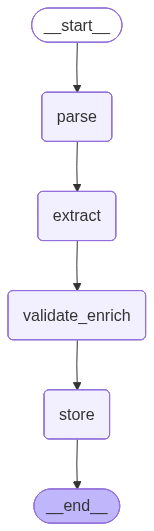

In [23]:
def should_continue(state: ResumeState) -> str:
    """
    Conditional edge to determine if workflow should continue or end
    """
    # Check if any previous step failed
    if state.get('parse_error'):
        return END
    if state.get('extract_error'):
        return END
    if state.get('validation_error'):
        return END
    if state.get('store_error'):
        return END
    
    return "continue"

def create_resume_workflow():
    """
    Create the LangGraph workflow for resume transformation
    """
    # Initialize the state graph
    workflow = StateGraph(ResumeState)
    
    # Add nodes (agents) to the graph
    workflow.add_node("parse", parse_agent)
    workflow.add_node("extract", extract_agent)
    workflow.add_node("validate_enrich", validate_and_enrich_agent)
    workflow.add_node("store", store_agent)
    
    # Define the flow: parse -> extract -> validate_enrich -> store
    workflow.set_entry_point("parse")
    workflow.add_edge("parse", "extract")
    workflow.add_edge("extract", "validate_enrich")
    workflow.add_edge("validate_enrich", "store")
    workflow.add_edge("store", END)
    
    # Compile the workflow
    app = workflow.compile()
    
    return app

# Create the workflow
resume_workflow = create_resume_workflow()

print("✓ LangGraph workflow created successfully!")


from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
display(Image(resume_workflow.get_graph().draw_mermaid_png()))

## Main Execution Function

Function to process a resume through the complete workflow.

In [19]:
def process_resume(file_path: str, db_path: str = "resume_ats.db") -> Dict[str, Any]:
    """
    Process a resume through the complete workflow
    
    Args:
        file_path: Path to the resume file (PDF, DOCX, or TXT)
        db_path: Path to the SQLite database
    
    Returns:
        Dictionary with processing results and status
    """
    print("="*80)
    print(f"🚀 RESUME TRANSFORMER WORKFLOW")
    print("="*80)
    
    # Determine file type
    file_extension = Path(file_path).suffix.lower().replace('.', '')
    
    # Initialize state
    initial_state: ResumeState = {
        'file_path': file_path,
        'file_type': file_extension,
        'raw_text': None,
        'parse_error': None,
        'structured_data': None,
        'extract_error': None,
        'validated_data': None,
        'validation_error': None,
        'database_id': None,
        'store_error': None,
        'status': 'processing',
        'messages': []
    }
    
    # Run the workflow
    try:
        # Execute the workflow with the store agent receiving db_path
        final_state = resume_workflow.invoke(initial_state)
        
        # Need to manually call store_agent with db_path since LangGraph doesn't support extra params
        if not final_state.get('validation_error'):
            final_state = store_agent(final_state, db_path)
        
        print("\n" + "="*80)
        print("📊 WORKFLOW SUMMARY")
        print("="*80)
        
        for message in final_state['messages']:
            print(f"  {message}")
        
        print(f"\n  Final Status: {final_state['status'].upper()}")
        
        if final_state.get('database_id'):
            print(f"  Database ID: {final_state['database_id']}")
        
        print("="*80)
        
        return {
            'success': final_state['status'] == 'completed',
            'database_id': final_state.get('database_id'),
            'candidate_name': final_state.get('validated_data', {}).get('contact', {}).get('name'),
            'messages': final_state['messages'],
            'state': final_state
        }
        
    except Exception as e:
        print(f"\n❌ Workflow failed: {str(e)}")
        return {
            'success': False,
            'error': str(e),
            'messages': [f"Fatal error: {str(e)}"]
        }

print("✓ Main execution function defined!")

✓ Main execution function defined!


## Test the Workflow

Let's test the workflow with a sample resume from the data folder.

In [24]:
# Set your OpenAI API key
# Uncomment and set your API key here:
# os.environ["OPENAI_API_KEY"] = "sk-your-api-key-here"

# Test with a sample resume - trying Image_10.pdf with OCR support
sample_resume = "data/Image_10.pdf"
sample_resume = "data/candidate_042.pdf"

# Process the resume with OCR
result = process_resume(sample_resume)

🚀 RESUME TRANSFORMER WORKFLOW
🔍 PARSE AGENT: Processing data/candidate_042.pdf
   ✓ Extracted 714 characters
🤖 EXTRACT AGENT: Analyzing resume with GPT-4o-mini
   ✓ Extracted data for: Ryan Nelson
✨ VALIDATE & ENRICH AGENT: Processing data
   ✓ Calculated 1.7 years of experience
   ✓ Standardized 6 skills to 6 unique skills
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 3
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 4

📊 WORKFLOW SUMMARY
  ✓ Successfully parsed 714 characters from PDF
  ✓ Successfully extracted structured data using GPT-4o-mini
  ✓ Successfully validated and enriched data
  ✓ Successfully stored candidate with ID 3
  ✓ Successfully stored candidate with ID 4

  Final Status: COMPLETED
  Database ID: 4


## View Results

Check the processed data and query the database.

In [25]:
# View the extracted and validated data
if result['success']:
    print("✅ Resume processed successfully!\n")
    
    validated_data = result['state']['validated_data']
    
    print("📋 CANDIDATE PROFILE")
    print("="*80)
    
    # Contact Information
    contact = validated_data.get('contact', {})
    print(f"\n👤 Contact Information:")
    print(f"   Name: {contact.get('name', 'N/A')}")
    print(f"   Email: {contact.get('email', 'N/A')}")
    print(f"   Phone: {contact.get('phone', 'N/A')}")
    print(f"   Location: {contact.get('location', 'N/A')}")
    
    # Experience Summary
    total_exp = validated_data.get('total_years_experience', 0)
    print(f"\n💼 Experience: {total_exp} years")
    
    # Skills
    skills = validated_data.get('skills', [])
    print(f"\n🛠️ Skills ({len(skills)}):")
    for i, skill in enumerate(skills[:10], 1):  # Show first 10
        print(f"   {i}. {skill}")
    if len(skills) > 10:
        print(f"   ... and {len(skills) - 10} more")
    
    # Education
    education = validated_data.get('education', [])
    print(f"\n🎓 Education:")
    for edu in education:
        print(f"   • {edu.get('degree', 'N/A')} in {edu.get('field', 'N/A')}")
        print(f"     {edu.get('institution', 'N/A')} ({edu.get('graduation_year', 'N/A')})")
    
    print("\n" + "="*80)
else:
    print("❌ Resume processing failed!")
    print(f"Error: {result.get('error', 'Unknown error')}")

✅ Resume processed successfully!

📋 CANDIDATE PROFILE

👤 Contact Information:
   Name: Ryan Nelson
   Email: N/A
   Phone: N/A
   Location: N/A

💼 Experience: 1.7 years

🛠️ Skills (6):
   1. C Programming
   2. Java
   3. Machine Learning
   4. Python
   5. SAP
   6. Software Engineering

🎓 Education:
   • B.Tech in Computer Science
     JNTU (2019)



In [27]:
# Set your OpenAI API key
# Uncomment and set your API key here:
# os.environ["OPENAI_API_KEY"] = "sk-your-api-key-here"

# Test with a sample resume - trying Image_10.pdf with OCR support
sample_resume = "data/Image_10.pdf"
sample_resume = "data/1901841_RESUME.pdf"

# Process the resume with OCR
result = process_resume(sample_resume)

🚀 RESUME TRANSFORMER WORKFLOW
🔍 PARSE AGENT: Processing data/1901841_RESUME.pdf
   ✓ Extracted 4568 characters
🤖 EXTRACT AGENT: Analyzing resume with GPT-4o-mini
   ✓ Extracted data for: Anuva Goyal
✨ VALIDATE & ENRICH AGENT: Processing data
   ✓ Calculated 0.2 years of experience
   ✓ Standardized 22 skills to 22 unique skills
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 5
💾 STORE AGENT: Saving to database
   ✓ Stored candidate with ID: 6

📊 WORKFLOW SUMMARY
  ✓ Successfully parsed 4568 characters from PDF
  ✓ Successfully extracted structured data using GPT-4o-mini
  ✓ Successfully validated and enriched data
  ✓ Successfully stored candidate with ID 5
  ✓ Successfully stored candidate with ID 6

  Final Status: COMPLETED
  Database ID: 6


In [28]:
# View the extracted and validated data
if result['success']:
    print("✅ Resume processed successfully!\n")
    
    validated_data = result['state']['validated_data']
    
    print("📋 CANDIDATE PROFILE")
    print("="*80)
    
    # Contact Information
    contact = validated_data.get('contact', {})
    print(f"\n👤 Contact Information:")
    print(f"   Name: {contact.get('name', 'N/A')}")
    print(f"   Email: {contact.get('email', 'N/A')}")
    print(f"   Phone: {contact.get('phone', 'N/A')}")
    print(f"   Location: {contact.get('location', 'N/A')}")
    
    # Experience Summary
    total_exp = validated_data.get('total_years_experience', 0)
    print(f"\n💼 Experience: {total_exp} years")
    
    # Skills
    skills = validated_data.get('skills', [])
    print(f"\n🛠️ Skills ({len(skills)}):")
    for i, skill in enumerate(skills[:10], 1):  # Show first 10
        print(f"   {i}. {skill}")
    if len(skills) > 10:
        print(f"   ... and {len(skills) - 10} more")
    
    # Education
    education = validated_data.get('education', [])
    print(f"\n🎓 Education:")
    for edu in education:
        print(f"   • {edu.get('degree', 'N/A')} in {edu.get('field', 'N/A')}")
        print(f"     {edu.get('institution', 'N/A')} ({edu.get('graduation_year', 'N/A')})")
    
    print("\n" + "="*80)
else:
    print("❌ Resume processing failed!")
    print(f"Error: {result.get('error', 'Unknown error')}")

✅ Resume processed successfully!

📋 CANDIDATE PROFILE

👤 Contact Information:
   Name: Anuva Goyal
   Email: anuvagoyal111@gmail.com
   Phone: +91 9520349542
   Location: N/A

💼 Experience: 0.2 years

🛠️ Skills (22):
   1. C
   2. C++
   3. CSS
   4. Code Blocks
   5. Data Structures
   6. Google Colab
   7. HTML
   8. Java
   9. JavaScript
   10. Jupyter Notebook
   ... and 12 more

🎓 Education:
   • B.Tech. in Electrical Engineering
     Dayalbagh Educational Institute (2023)
   • None in None
     St. Clare’s Senior Secondary School (2019)
   • None in None
     St. Clare’s Senior Secondary School (2017)



## Query Database

Let's query the database to see the stored records.

In [31]:
def query_database(db_path: str = "resume_ats.db"):
    """Query and display all candidates in the database"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Get all candidates
    cursor.execute('''
        SELECT id, name, email, phone, location, total_years_experience, created_at
        FROM candidates
        ORDER BY created_at DESC
    ''')
    
    candidates = cursor.fetchall()
    
    print("\n📊 CANDIDATES IN DATABASE")
    print("="*100)
    
    if not candidates:
        print("No candidates found in database.")
    else:
        print(f"{'ID':<5} {'Name':<25} {'Email':<30} {'Experience':<12} {'Created':<20}")
        print("-"*100)
        
        for candidate in candidates:
            cid, name, email, phone, location, exp, created = candidate
            # Handle None values safely
            name_str = (name[:24] if name else 'N/A')
            email_str = (email[:29] if email else 'N/A')
            exp_str = str(exp) if exp is not None else 'N/A'
            created_str = (created[:19] if created else 'N/A')
            print(f"{cid:<5} {name_str:<25} {email_str:<30} {exp_str:<12} {created_str:<20}")
        
        print("-"*100)
        print(f"Total candidates: {len(candidates)}")
    
    # Get skills for latest candidate
    if candidates:
        latest_id = candidates[0][0]
        cursor.execute('SELECT skill FROM skills WHERE candidate_id = ?', (latest_id,))
        skills = [row[0] for row in cursor.fetchall()]
        
        if skills:
            print(f"\n🛠️ Skills for candidate {latest_id} ({candidates[0][1]}):")
            print(", ".join(skills[:15]))
            if len(skills) > 15:
                print(f"... and {len(skills) - 15} more")
    
    conn.close()

# Query the database
query_database()


📊 CANDIDATES IN DATABASE
ID    Name                      Email                          Experience   Created             
----------------------------------------------------------------------------------------------------
5     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-25 10:51:09 
6     Anuva Goyal               anuvagoyal111@gmail.com        0.2          2025-12-25 10:51:09 
3     Ryan Nelson               N/A                            1.7          2025-12-25 10:48:43 
4     Ryan Nelson               N/A                            1.7          2025-12-25 10:48:43 
1     Elijah Harrison           example-email@example.com      21.2         2025-12-25 10:46:52 
2     Elijah Harrison           example-email@example.com      21.2         2025-12-25 10:46:52 
----------------------------------------------------------------------------------------------------
Total candidates: 6

🛠️ Skills for candidate 5 (Anuva Goyal):
C, C++, CSS, Code Blocks, Data 

## Batch Processing

Process multiple resumes from the data folder.

In [ ]:
def batch_process_resumes(folder_path: str, db_path: str = "resume_ats.db", limit: int = None):
    """
    Process multiple resumes from a folder
    
    Args:
        folder_path: Path to folder containing resume files
        db_path: Path to database
        limit: Maximum number of resumes to process (None for all)
    """
    folder = Path(folder_path)
    resume_files = list(folder.glob("*.pdf")) + list(folder.glob("*.docx")) + list(folder.glob("*.txt"))
    
    if limit:
        resume_files = resume_files[:limit]
    
    print(f"\n📦 BATCH PROCESSING: {len(resume_files)} resumes")
    print("="*80)
    
    results = {
        'successful': 0,
        'failed': 0,
        'details': []
    }
    
    for i, resume_file in enumerate(resume_files, 1):
        print(f"\n[{i}/{len(resume_files)}] Processing: {resume_file.name}")
        
        try:
            result = process_resume(str(resume_file), db_path)
            
            if result['success']:
                results['successful'] += 1
                results['details'].append({
                    'file': resume_file.name,
                    'status': 'success',
                    'candidate': result.get('candidate_name'),
                    'db_id': result.get('database_id')
                })
            else:
                results['failed'] += 1
                results['details'].append({
                    'file': resume_file.name,
                    'status': 'failed',
                    'error': result.get('error')
                })
        except Exception as e:
            results['failed'] += 1
            results['details'].append({
                'file': resume_file.name,
                'status': 'error',
                'error': str(e)
            })
    
    print("\n" + "="*80)
    print(f"📊 BATCH SUMMARY")
    print("="*80)
    print(f"  Total processed: {len(resume_files)}")
    print(f"  ✅ Successful: {results['successful']}")
    print(f"  ❌ Failed: {results['failed']}")
    print("="*80)
    
    return results

# Example: Process first 3 resumes from data folder (uncomment to run)
# batch_results = batch_process_resumes("data", limit=3)

## Advanced Queries

Some useful queries for searching the ATS database.

In [ ]:
def search_by_skill(skill: str, db_path: str = "resume_ats.db"):
    """Search candidates by skill"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute('''
        SELECT DISTINCT c.id, c.name, c.email, c.total_years_experience
        FROM candidates c
        JOIN skills s ON c.id = s.candidate_id
        WHERE s.skill LIKE ?
        ORDER BY c.total_years_experience DESC
    ''', (f'%{skill}%',))
    
    results = cursor.fetchall()
    
    print(f"\n🔍 Candidates with skill: {skill}")
    print("="*80)
    
    if results:
        for cid, name, email, exp in results:
            print(f"  • {name} ({exp or 'N/A'} years) - {email}")
    else:
        print(f"  No candidates found with skill: {skill}")
    
    conn.close()
    return results

def search_by_experience(min_years: float, db_path: str = "resume_ats.db"):
    """Search candidates by minimum years of experience"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute('''
        SELECT id, name, email, total_years_experience
        FROM candidates
        WHERE total_years_experience >= ?
        ORDER BY total_years_experience DESC
    ''', (min_years,))
    
    results = cursor.fetchall()
    
    print(f"\n🔍 Candidates with {min_years}+ years of experience")
    print("="*80)
    
    if results:
        for cid, name, email, exp in results:
            print(f"  • {name} ({exp} years) - {email}")
    else:
        print(f"  No candidates found with {min_years}+ years")
    
    conn.close()
    return results

# Example searches (uncomment to run after processing resumes)
# search_by_skill("Python")
# search_by_experience(5.0)

## Workflow Visualization

The LangGraph workflow follows this structure:

```
┌─────────────────────────────────────────────────────────────────┐
│                   RESUME TRANSFORMER WORKFLOW                   │
└─────────────────────────────────────────────────────────────────┘

                        ┌──────────────┐
                        │   START      │
                        └──────┬───────┘
                               │
                               ▼
                     ┌─────────────────┐
                     │  1. PARSE       │
                     │  Extract Text   │
                     └────────┬────────┘
                              │
                              ▼
                     ┌─────────────────┐
                     │  2. EXTRACT     │
                     │  LLM Analysis   │
                     │  (GPT-4o-mini)  │
                     └────────┬────────┘
                              │
                              ▼
                     ┌─────────────────┐
                     │  3. VALIDATE    │
                     │  & ENRICH       │
                     │  • Clean Data   │
                     │  • Calc Exp     │
                     │  • Standardize  │
                     └────────┬────────┘
                              │
                              ▼
                     ┌─────────────────┐
                     │  4. STORE       │
                     │  Insert to DB   │
                     └────────┬────────┘
                              │
                              ▼
                        ┌──────────────┐
                        │    END       │
                        └──────────────┘
```

### Features:
- ✅ **Multi-format support**: PDF, DOCX, TXT
- ✅ **LLM-powered extraction**: Uses GPT-4o-mini for intelligent parsing
- ✅ **Data validation**: Cleans and normalizes data
- ✅ **Experience calculation**: Automatically computes total years
- ✅ **Skill standardization**: Maps to company taxonomy
- ✅ **Database storage**: Structured SQL schema for ATS
- ✅ **Batch processing**: Handle multiple resumes
- ✅ **Search capabilities**: Query by skills, experience, etc.